<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/CNN/RCNN/08_04_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 範例4. R-CNN

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -fs /content/gdrive/My\ Drive /app
%cd /app/DL_Book/
!git clone https://github.com/1297rohit/RCNN.git
!cp RCNN/Images.zip images_Object_Detection
!cp RCNN/Airplanes_Annotations.zip images_Object_Detection

Mounted at /content/gdrive
/content/gdrive/My Drive/DL_Book
Cloning into 'RCNN'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 0), reused 2 (delta 0), pack-reused 22
Unpacking objects: 100% (25/25), done.


In [3]:
!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 56.1 MB 35 kB/s 


## 需安裝 opencv 擴展版

#### pip uninstall opencv-contrib-python opencv-python
#### pip install opencv-contrib-python

In [4]:
import zipfile
import os

# 圖像訓練資料
path_to_zip_file = './images_Object_Detection/Images.zip'
directory_to_extract_to = './images_Object_Detection/'

# 檢查目錄是否存在 
if not os.path.isdir(directory_to_extract_to):
    # 解壓縮
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [5]:
# 標註訓練資料
path_to_zip_file = './images_Object_Detection/Airplanes_Annotations.zip'
directory_to_extract_to = './images_Object_Detection/'

# 檢查目錄是否存在 
if not os.path.isdir(directory_to_extract_to):
    # 解壓縮
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [6]:
# 載入套件
import os,cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

airplane_027.jpg


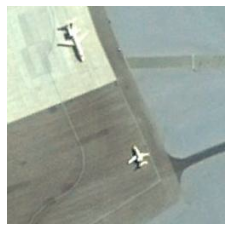

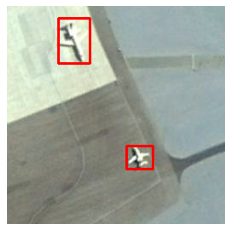

In [11]:
# 設定圖像及標註目錄
path = "./images_Object_Detection/Images"
annot = "./images_Object_Detection/Airplanes_Annotations"

# 顯示1張圖像訓練資料含標註
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        # 讀取圖像
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i),engine='python')
        plt.axis('off')
        plt.imshow(img)
        # (x1, y1)：左上角座標，(x2, y2)：右下角座標
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.axis('off')
        plt.imshow(img)
        break

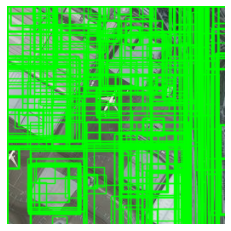

In [12]:
# 區域推薦(Region Proposal)：Selective Search
# 讀取圖像
im = cv2.imread(os.path.join(path,"42850.jpg"))

# Selective Search
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# 輸出
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.axis('off')    
plt.imshow(imOut)

In [13]:
# 定義 IoU 計算函數
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [14]:
# 篩選訓練資料

# 儲存正樣本及負樣本的候選框
train_images=[]
train_labels=[]

# 掃描每一個標註
for e,i in enumerate(os.listdir(annot)):
    try:
        # 取得飛機的圖像
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            
            # 讀取標註檔案
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            
            # 取得所有標註的座標
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                
            # 區域推薦
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            
            # 初始化
            counter = 0       # 正樣本筆數
            falsecounter = 0  # 負樣本筆數
            flag = 0          # 1:正負樣本筆數均 >= 30
            fflag = 0         # 1:正樣本筆數 >= 30
            bflag = 0         # 1:負樣本筆數 >= 30
            
            # 掃描每一個候選框
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        # 比較區域推薦區域與標註的 IoU
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        
                        # 收集30筆正樣本    
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), 
                                                     interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                            
                        # 收集30筆負樣本    
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), 
                                                     interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                            
                    # 超過30筆正樣本及負樣本，表有物件在框裡面 
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_027.jpg
1 airplane_030.jpg
2 airplane_033.jpg
3 airplane_035.jpg
4 airplane_038.jpg
5 airplane_041.jpg
inside
6 airplane_043.jpg
7 airplane_046.jpg
8 airplane_049.jpg
9 airplane_051.jpg
10 airplane_057.jpg
11 airplane_054.jpg
12 airplane_059.jpg
13 airplane_062.jpg
inside
14 airplane_065.jpg
15 airplane_067.jpg
16 airplane_070.jpg
17 airplane_072.jpg
18 airplane_073.jpg
19 airplane_074.jpg
20 airplane_077.jpg
21 airplane_075.jpg
inside
22 airplane_076.jpg
23 airplane_079.jpg
24 airplane_086.jpg
25 airplane_085.jpg
inside
26 airplane_084.jpg
27 airplane_083.jpg
inside
28 airplane_081.jpg
29 airplane_082.jpg
30 airplane_080.jpg
31 airplane_078.jpg
32 airplane_090.jpg
33 airplane_087.jpg
34 airplane_089.jpg
35 airplane_088.jpg
36 airplane_091.jpg
37 airplane_094.jpg
38 airplane_095.jpg
39 airplane_093.jpg
40 airplane_092.jpg
41 airplane_025.jpg
42 airplane_022.jpg
43 airplane_019.jpg
44 airplane_066.jpg
45 airplane_071.jpg
46 airplane_068.jpg
47 airplane_069.jpg
73 airplane_001

In [15]:
from joblib import dump
dump(train_images, 'train_images.joblib')
dump(train_labels, 'train_labels.joblib')


['train_labels.joblib']

In [16]:
from joblib import load
train_images = load('train_images.joblib')
train_labels = load('train_labels.joblib')

In [17]:
len(train_images)

30229

In [18]:
# 定義模型
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=True)

# VGG16 前端的神經層不重作訓練
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

# 接自訂神經層作辨識
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)

# 訂定損失函數、優化器、效能衡量指標
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)
model_final.compile(loss = tf.keras.losses.categorical_crossentropy, 
                    optimizer = opt, metrics=["accuracy"])
model_final.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
# 定義函數，將標記 Y 轉為二個變數，
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [20]:
# 資料前置處理，切割訓練及測試資料
from sklearn.model_selection import train_test_split

# 筆者 PC 記憶體不足，只取 10000
X_new = np.array(train_images[:10000])
y_new = np.array(train_labels[:10000])

# 標記 Y 轉為二個變數，
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

# 切割訓練及測試資料
X_train, X_test , y_train, y_test = train_test_split(X_new, Y, test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(9000, 224, 224, 3) (1000, 224, 224, 3) (9000, 2) (1000, 2)


In [ ]:
# 資料增補(Data Augmentation)
trdata = ImageDataGenerator(horizontal_flip=True, 
                            vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, 
                            vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [1]:
# 模型訓練
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 定義模型存檔及提早結束的 Callback
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', 
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, 
                      verbose=1, mode='auto')

# 模型訓練，節省時間，只訓練 20 epochs，正式專案還是要訓練較多週期
# hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, 
#        epochs= 1000, validation_data= testdata, validation_steps=2, 
#        callbacks=[checkpoint,early])
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, 
         epochs= 20, validation_data= testdata, validation_steps=2, 
         callbacks=[checkpoint,early])

NameError: ignored

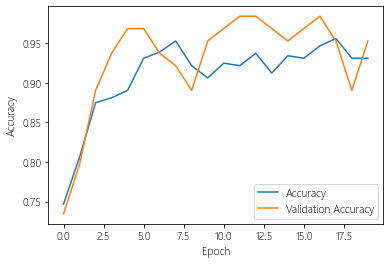

In [ ]:
# 繪製模型訓練過程的準確率
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

有飛機


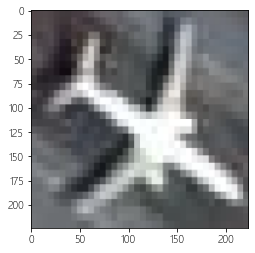

In [ ]:
# 任選一張圖片測試
im = X_test[100]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)

# 顯示預測結果
if out[0][0] > out[0][1]:
    print("有飛機")
else:
    print("沒有飛機")

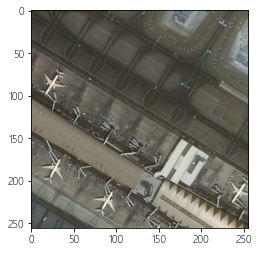

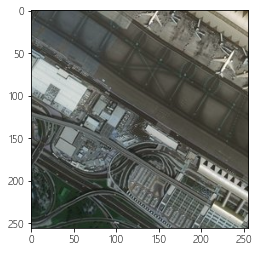

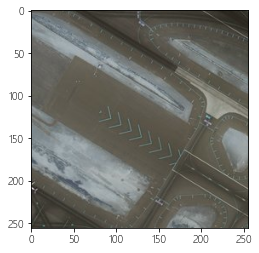

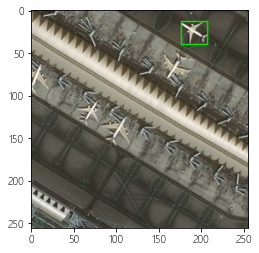

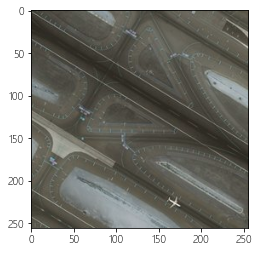

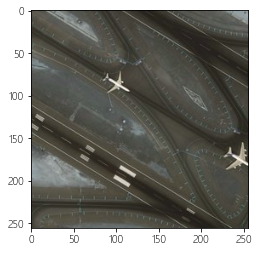

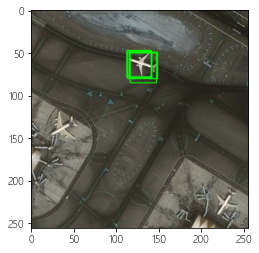

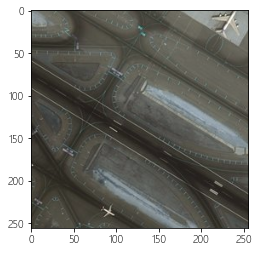

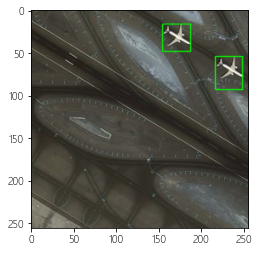

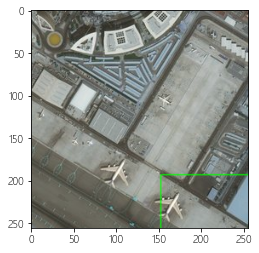

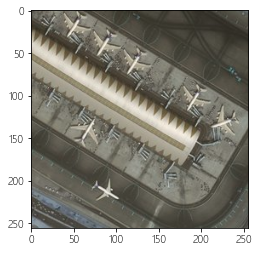

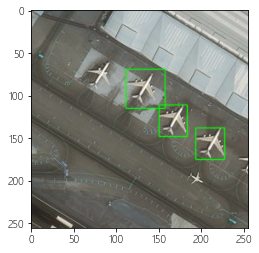

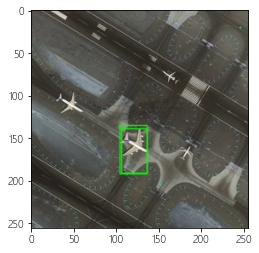

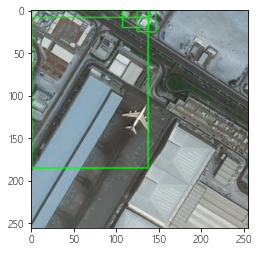

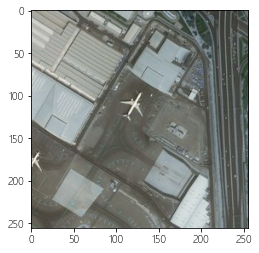

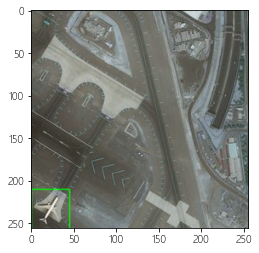

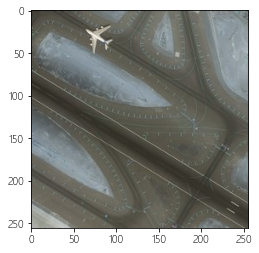

In [ ]:
# 測試所有檔名為 4 開頭的檔案
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        # 區域推薦
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        
        # 物件偵測
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                
                # 機率 > 0.65 才算偵測到飛機
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)